In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label, filter_df_by_label
from lr.text_processing.transformations.wordnet import path_base_transformation
from lr.training.language_representation import Tfidf
from lr.training.util import get_ternary_label
from lr.models.logistic_regression import LRWrapper
from lr.stats.h_testing import LIMts_test
from IPython.display import display, HTML 
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Loading data

In [2]:
train_path = "data/snli/train.csv"
dev_path = "data/snli/dev.csv"

train_path_mod = "data/snli/train_p_h_syn_noun.csv"
dev_path_mod = "data/snli/dev_p_h_syn_noun.csv"

train_trans = lambda df: path_base_transformation(df, train_path_mod)
dev_trans = lambda df: path_base_transformation(df, dev_path_mod)


train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
train = filter_df_by_label(train.dropna()).reset_index(drop=True)
dev = filter_df_by_label(dev.dropna()).reset_index(drop=True)

train = train.head(10000)
dev = dev.head(1000)

dev_t = dev_trans(dev)

pre_process_nli_df(train)
pre_process_nli_df(dev)

print(train.shape)
print(dev.shape)

(10000, 3)
(1000, 3)


### Params

In [3]:
max_features = None

param_grid = {"C": np.linspace(0, 3, 50),
              "penalty":["l2"]}


hyperparams = {"RepresentationFunction": Tfidf,
               "cv":5,
               "solver": 'lbfgs',
               "random_state": None,
               "verbose":False,
               "n_jobs":1,
               "n_iter":2,
               "max_features": max_features,
               "label_translation": get_ternary_label,
               "param_grid": param_grid}

In [4]:
results = LIMts_test(train=train,
               dev=dev,
               train_transformation=train_trans,
               dev_transformation=dev_trans,
               rho=0.3,
               Model=LRWrapper,
               hyperparams=hyperparams,
               M=3,
               E=5,
               S=1000,
               verbose=True,
               random_state=1234)

m = 1 | time: 72.81 sec
m = 2 | time: 79.05 sec
m = 3 | time: 85.08 sec


### All Results

In [5]:
not_boot_columns = [c for c in results.columns if c.find("boot") == -1]
display(HTML(results[not_boot_columns].to_html()))

,m,train_accuracy_mean,train_accuracy_std,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,test_time
0,1,0.50180,0.001221,0.499,0.505,-0.447258,0.658,0.834424,68.490654,72.808838
1,2,0.49510,0.002454,0.511,0.503,0.606590,0.584,1.020370,75.013980,79.045465
2,3,0.49984,0.002221,0.509,0.505,0.296513,0.774,0.953750,81.008651,85.081209


### Especific result for one noised sample

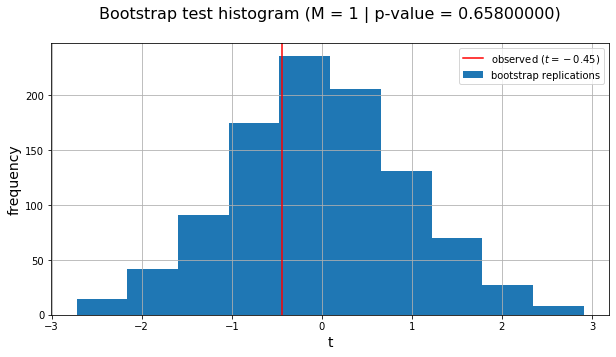

In [15]:
id_ = 0

results_id = results.iloc[id_].to_frame().transpose().reset_index(drop=True)
t_obs = results_id.observable_t_stats[0]
p_value = results_id.p_value[0]


boot_columns = [c for c in results_id.columns if c.find("boot") > -1]

t_boots = results_id[boot_columns].transpose()


fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label=r"observed ($t= {:.2f})$".format(t_obs));
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (M = {} | p-value = {:.8f})".format(id_+1, p_value) +"\n", fontsize=16)
plt.legend(loc="best");